# Chapter 10

## Building an Image Classifier Using the Sequential API

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

In [2]:
root_dir = '../data'
full_train_dset = FashionMNIST(root=root_dir, train=True, transform=ToTensor())
test_dset = FashionMNIST(root=root_dir, train=False, transform=ToTensor())

In [3]:
device = 'cuda'
torch.cuda.set_device(1)

In [4]:
train_dset = Subset(full_train_dset, indices=range(55000))
valid_dset = Subset(full_train_dset, indices=range(55000, 60000))

In [5]:
len(train_dset), len(valid_dset)

(55000, 5000)

In [6]:
batch_size = 32 # Default batch size on keras

In [7]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

## Normalization

In Geron's book the data are normalized by dividing by 255. The `ToTensor()` transform added to the Dataset definition takes care of this automatically.

In [8]:
img, tgt = next(iter(valid_loader))

In [9]:
img.max()

tensor(1.)

In [10]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [11]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=784, out_features=300),
            nn.ReLU(),
            nn.Linear(in_features=300, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=10))
    
    def forward(self, x):
        return self.sequential_model(x)

In [12]:
classif_model = MyModel()
classif_model

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [13]:
classif_model.sequential_model[1].bias[0]

tensor(0.0266, grad_fn=<SelectBackward0>)

In [14]:
classif_model.sequential_model[1].weight[0, :10]

tensor([ 0.0204,  0.0288, -0.0225,  0.0327, -0.0294, -0.0334, -0.0026, -0.0229,
         0.0068, -0.0127], grad_fn=<SliceBackward0>)

## Weight initialization

In Keras weights in a dense layer are, [by default](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), initialized with a Glorot Uniform initialization.

In Pytorch weights in a linear layer are, [by default](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear) initialized with a uniform distribution with  U(−k,k) where k=1/in_features. This is essentially a LeCun uniform initialization. Note that in PyTorch, Glorot initialization is called Xavier initialization.

In [15]:
@torch.no_grad()
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.)

In [16]:
classif_model.apply(init_weights)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [17]:
classif_model.sequential_model[1].bias[0]

tensor(0., grad_fn=<SelectBackward0>)

In [18]:
classif_model.sequential_model[1].weight[0, :10]

tensor([-0.0656, -0.0106,  0.0261,  0.0037, -0.0222,  0.0252, -0.0580, -0.0723,
         0.0665, -0.0372], grad_fn=<SliceBackward0>)

Both the bias and the weight look different. We assume that we are using the same initialization approach as Keras.

The Keras model has a final softmax activation. If we use PyTorch cross-entropy loss, the softmax is fused in the loss, so we don't need to include it.

In [19]:
classif_model.to(device)

MyModel(
  (sequential_model): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=300, bias=True)
    (2): ReLU()
    (3): Linear(in_features=300, out_features=100, bias=True)
    (4): ReLU()
    (5): Linear(in_features=100, out_features=10, bias=True)
  )
)

In [20]:
loss_fn = torch.nn.CrossEntropyLoss()

## Optimizers

The example in Geron's book uses the "sgd" optimizer, which I suspect corresponds to the [default settings](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/experimental/SGD), i.e., lr = 0.01 and momentum = 0.0.

In [21]:
classif_optim = optim.SGD(classif_model.parameters(), lr=0.01, momentum=0.0)

In [22]:
def train(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 250 == 0:
            print(f'Train loss: {batch_loss.item():>.5}')

In [23]:
def validate(dataloader, model, loss_fn):
    num_batches = len(dataloader)
    num_obs = len(dataloader.dataset)
    total_loss = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
            correct += (preds.argmax(1) == y).type(torch.float).sum().item()
    avg_batch_loss = total_loss / num_batches
    accuracy = correct / num_obs
    print('Validation:')
    print(f'\nAverage loss: {avg_batch_loss:>.5} - Accuracy: {accuracy:>.3}')
    return avg_batch_loss, accuracy

In [24]:
epochs = 30

In [25]:
test_loss, test_accuracy = [], []

for epoch in range(epochs):
    print(f'\n----- Epoch: {epoch+1} -----\n')
    train(train_loader, classif_model, loss_fn, classif_optim)
    loss, acc = validate(valid_loader, classif_model, loss_fn)
    test_loss.append(loss)
    test_accuracy.append(acc)


----- Epoch: 1 -----

Train loss: 2.3058
Train loss: 1.0391
Train loss: 0.85956
Train loss: 0.3464
Train loss: 0.53134
Train loss: 0.72127
Train loss: 0.48757
Validation:

Average loss: 0.50148 - Accuracy: 0.822

----- Epoch: 2 -----

Train loss: 0.44929
Train loss: 0.38813
Train loss: 0.49855
Train loss: 0.49606
Train loss: 0.27502
Train loss: 0.52811
Train loss: 0.36798
Validation:

Average loss: 0.43963 - Accuracy: 0.842

----- Epoch: 3 -----

Train loss: 0.35291
Train loss: 0.31095
Train loss: 0.48646
Train loss: 0.35662
Train loss: 0.70252
Train loss: 0.44499
Train loss: 0.6641
Validation:

Average loss: 0.43742 - Accuracy: 0.841

----- Epoch: 4 -----

Train loss: 0.328
Train loss: 0.41367
Train loss: 0.49587
Train loss: 0.50233
Train loss: 0.42328
Train loss: 0.35917
Train loss: 0.57238
Validation:

Average loss: 0.40377 - Accuracy: 0.855

----- Epoch: 5 -----

Train loss: 0.27483
Train loss: 0.22167
Train loss: 0.56337
Train loss: 0.26774
Train loss: 0.50743
Train loss: 0.59859

This is very similar to the performance shown in Geron's book.

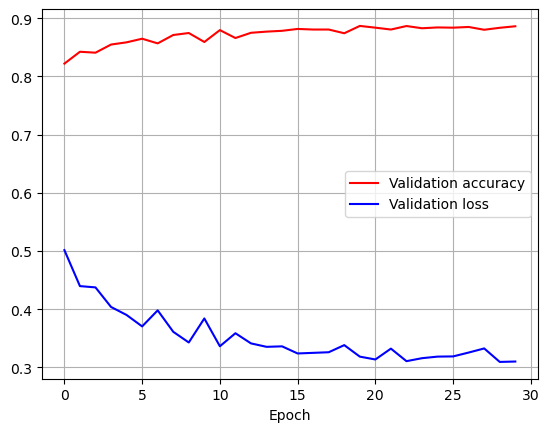

In [26]:
plt.plot(np.arange(30), test_accuracy, 'r-', label='Validation accuracy')
plt.plot(np.arange(30), test_loss, 'b-', label='Validation loss')
plt.grid()
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Performance on the test set

In [27]:
def get_test_performance(dataloader, model):
    test_accuracy = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            correct += (preds.argmax(1) == y).type(torch.float32).sum().item()
    return correct / len(dataloader.dataset)

In [28]:
get_test_performance(test_loader, classif_model)

0.8822

## Building a Regression MLP Using the Sequential API

For this example we use the California Housing dataset. After creating a training, validation, and test set, we must normalize the data and organize them into dataloaders.

In [29]:
housing = fetch_california_housing()
x_train_full, x_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_full, y_train_full, random_state=42)

In [30]:
x_train.shape, x_valid.shape, x_test.shape

((11610, 8), (3870, 8), (5160, 8))

In [31]:
x_test[0]

array([ 1.68120000e+00,  2.50000000e+01,  4.19220056e+00,  1.02228412e+00,
        1.39200000e+03,  3.87743733e+00,  3.60600000e+01, -1.19010000e+02])

In [32]:
means, std_devs = x_train.mean(axis=0), x_train.std(axis=0)
means.shape, std_devs.shape

((8,), (8,))

In [33]:
x_train = ((x_train - means) / std_devs).astype(np.float32)
x_valid = ((x_valid - means) / std_devs).astype(np.float32)
x_test = ((x_test - means) / std_devs).astype(np.float32)

In [34]:
x_test.dtype

dtype('float32')

In [35]:
train_dset = TensorDataset(torch.FloatTensor(x_train),
                           torch.FloatTensor(y_train).unsqueeze(-1))
valid_dset = TensorDataset(torch.FloatTensor(x_valid),
                           torch.FloatTensor(y_valid).unsqueeze(-1))
test_dset = TensorDataset(torch.FloatTensor(x_test),
                          torch.FloatTensor(y_test).unsqueeze(-1))

In [36]:
train_loader = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dset, batch_size=batch_size, shuffle=False)

In [37]:
class RegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential_model = nn.Sequential(
            nn.Linear(in_features=8, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=50),
            nn.ReLU(),
            nn.Linear(in_features=50, out_features=1))
    
    def forward(self, x):
        return self.sequential_model(x)

### Weight initialization

In [38]:
regression_model = RegressionModel()
regression_model.apply(init_weights)

RegressionModel(
  (sequential_model): Sequential(
    (0): Linear(in_features=8, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): ReLU()
    (6): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [39]:
regression_model = regression_model.to(device)

In [40]:
def train_regression(dataloader, model, loss_fn, optimizer):
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        preds = model(x)
        batch_loss = loss_fn(preds, y)
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        if batch % 100 == 0:
            print(f'Train Loss: {batch_loss.item():>.5}. Batch: [{batch}/{num_batches}]')

In [41]:
def eval_regression(dataloader, model, loss_fn):
    total_loss = 0
    num_obs = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            total_loss += loss_fn(preds, y).item()
        print(f'Validation Loss: {total_loss/num_batches:>.5}')

In [42]:
loss_fn = nn.MSELoss()
regression_optim = optim.Adam(regression_model.parameters(), lr=1e-3, eps=1e-7)

In [43]:
for epoch in range(20):
    print(f'\n ----- Epoch {epoch+1} -----\n')
    train_regression(train_loader, regression_model, loss_fn, regression_optim)
    eval_regression(valid_loader, regression_model, loss_fn)


 ----- Epoch 1 -----

Train Loss: 4.6812. Batch: [0/363]
Train Loss: 0.61528. Batch: [100/363]
Train Loss: 0.3824. Batch: [200/363]
Train Loss: 0.35226. Batch: [300/363]
Validation Loss: 0.493

 ----- Epoch 2 -----

Train Loss: 0.28571. Batch: [0/363]
Train Loss: 0.39985. Batch: [100/363]
Train Loss: 0.356. Batch: [200/363]
Train Loss: 0.60781. Batch: [300/363]
Validation Loss: 2.5737

 ----- Epoch 3 -----

Train Loss: 0.50656. Batch: [0/363]
Train Loss: 0.36145. Batch: [100/363]
Train Loss: 0.27962. Batch: [200/363]
Train Loss: 0.23393. Batch: [300/363]
Validation Loss: 2.3216

 ----- Epoch 4 -----

Train Loss: 0.52253. Batch: [0/363]
Train Loss: 0.18368. Batch: [100/363]
Train Loss: 0.33468. Batch: [200/363]
Train Loss: 0.27719. Batch: [300/363]
Validation Loss: 1.373

 ----- Epoch 5 -----

Train Loss: 0.52883. Batch: [0/363]
Train Loss: 0.83932. Batch: [100/363]
Train Loss: 0.29432. Batch: [200/363]
Train Loss: 0.37331. Batch: [300/363]
Validation Loss: 1.9102

 ----- Epoch 6 -----

## Building Complex Models Using the Functional API

In [44]:
class WideAndDeep(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_layer1 = nn.Linear(in_features=8, out_features=30)
        self.relu = nn.ReLU()
        self.hidden_layer2 = nn.Linear(in_features=30, out_features=30)
        self.output_layer = nn.Linear(in_features=38, out_features=1)
    
    def forward(self, x):
        z = self.relu(self.hidden_layer1(x))
        z = self.relu(self.hidden_layer2(z))
        w = torch.cat((x, z), dim=-1)
        return self.output_layer(w)

In [45]:
widedeep = WideAndDeep()
widedeep.apply(init_weights)
widedeep = widedeep.to(device)

Note that we need to create another optimizer, as the existing one has been trained on a different architecture.

In [46]:
wnd_optim = optim.Adam(widedeep.parameters(), lr=1e-3, eps=1e-7)

In [47]:
for epoch in range(20):
    train_regression(train_loader, widedeep, loss_fn, wnd_optim)
    eval_regression(valid_loader, widedeep, loss_fn)

Train Loss: 8.6954. Batch: [0/363]
Train Loss: 1.3159. Batch: [100/363]
Train Loss: 0.85891. Batch: [200/363]
Train Loss: 1.1598. Batch: [300/363]
Validation Loss: 0.90985
Train Loss: 0.59334. Batch: [0/363]
Train Loss: 0.59671. Batch: [100/363]
Train Loss: 0.54503. Batch: [200/363]
Train Loss: 0.30858. Batch: [300/363]
Validation Loss: 1.5062
Train Loss: 0.47393. Batch: [0/363]
Train Loss: 0.44183. Batch: [100/363]
Train Loss: 0.48225. Batch: [200/363]
Train Loss: 0.54218. Batch: [300/363]
Validation Loss: 0.39961
Train Loss: 0.16247. Batch: [0/363]
Train Loss: 0.40491. Batch: [100/363]
Train Loss: 0.11579. Batch: [200/363]
Train Loss: 0.65929. Batch: [300/363]
Validation Loss: 0.36242
Train Loss: 0.47726. Batch: [0/363]
Train Loss: 0.44288. Batch: [100/363]
Train Loss: 1.3181. Batch: [200/363]
Train Loss: 0.40701. Batch: [300/363]
Validation Loss: 1.0855
Train Loss: 0.16801. Batch: [0/363]
Train Loss: 0.27146. Batch: [100/363]
Train Loss: 0.38227. Batch: [200/363]
Train Loss: 0.19793